https://github.com/bentrevett/pytorch-seq2seq

# Seq 2 Seq

Tutorial Seq 2 Seq de ingles para alemão

# Preparing Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import spacy
import numpy as np

import random
import math
import time

In [3]:
from functions import *


Seed for reproduction

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [7]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

c:\Users\vormenesse\anaconda3\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'de_core_news_sm' (3.3.0) was trained with spaCy v3.3.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
c:\Users\vormenesse\anaconda3\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [8]:
spacy_de.vocab.length,spacy_en.vocab.length

(680, 772)

In [9]:
with open('train.en') as f:
    trainEn = f.readlines()
with open('train.de') as f:
    trainDe = f.readlines()
with open('val.en') as f:
    valEn = f.readlines()
with open('val.de') as f:
    valDe = f.readlines()

In [10]:
engVocabulary = Vocabulary('en',spacy_en,40)
deVocabulary = Vocabulary('de',spacy_de,40)

In [11]:
for i in trainEn:
  engVocabulary.add_sentence(i)
for i in trainDe:
  deVocabulary.add_sentence(i)
for i in valEn:
  engVocabulary.add_sentence(i)
for i in valDe:
  deVocabulary.add_sentence(i)

In [12]:
engVocabulary.num_words,deVocabulary.num_words

(9951, 19062)

In [13]:
engVocabulary.longest_sentence,deVocabulary.longest_sentence

(41, 44)

In [14]:
deVocabulary.sentence_to_index(trainDe[100],padding=True)

[1,
 461,
 462,
 11,
 30,
 169,
 215,
 50,
 166,
 209,
 59,
 30,
 463,
 464,
 16,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [15]:
engVocabulary.sentence_to_index(trainEn[100])

[1, 447, 241, 17, 21, 169, 155, 298, 36, 116, 373, 448, 14, 2]

In [16]:
src = []
for j in np.array(trainEn):
    src.append(engVocabulary.sentence_to_index(j,padding=True))
src = torch.tensor(src,dtype=torch.long, device=device)
trg = []
for j in np.array(trainDe):
    trg.append(deVocabulary.sentence_to_index(j,padding=True))
trg = torch.tensor(trg,dtype=torch.long, device=device)
trg = trg.T
src = src.T

In [17]:
valsrc = []
for j in np.array(valEn):
    valsrc.append(engVocabulary.sentence_to_index(j,padding=True))
valsrc = torch.tensor(valsrc,dtype=torch.long, device=device)
valtrg = []
for j in np.array(valDe):
    valtrg.append(deVocabulary.sentence_to_index(j,padding=True))
valtrg = torch.tensor(valtrg,dtype=torch.long, device=device)
valtrg = valtrg.T
valsrc = valsrc.T

# LSTM

## Building Model

https://arxiv.org/abs/1409.3215

In [30]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, src):
     embedded = self.dropout(self.embedding(src))
     outputs, (hidden, cell) = self.rnn(embedded)
     #outputs are always from the top hidden layer
     return hidden, cell

In [31]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()
    self.output_dim = output_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
    self.fc_out = nn.Linear(hid_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, cell):
    input = input.unsqueeze(0)
    embedded = self.dropout(self.embedding(input))
    output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
    prediction = self.fc_out(output.squeeze(0))
    return prediction, hidden, cell

In [32]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    assert encoder.hid_dim == decoder.hid_dim, \
        "Hidden dimensions of encoder and decoder must be equal!"
    # should be equal because it is easier
    assert encoder.n_layers == decoder.n_layers, \
        "Encoder and decoder must have equal number of layers!"
  def forward(self, src, trg, teacher_forcing_ratio=0.5):
    batch_size = trg.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim
    #tensor to store decoder outputs
    outputs_text = torch.zeros(trg_len, batch_size).to(self.device)
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    #print('outputs.shape',outputs.shape)
    #last hidden state of the encoder is used as the initial hidden state of the decoder
    hidden, cell = self.encoder(src)
    #first input to the decoder is the <sos> tokens
    input = trg[0,:]
    outputs_text[0] = input
    #print('input.shape',input.shape)
    for t in range(1, trg_len):
      #insert input token embedding, previous hidden and previous cell states
      #receive output tensor (predictions) and new hidden and cell states
      output, hidden, cell = self.decoder(input, hidden, cell)
      #place predictions in a tensor holding predictions for each token
      #outputs[t] = output
      #decide if we are going to use teacher forcing or not
      teacher_force = random.random() < teacher_forcing_ratio
      #get the highest predicted token from our predictions
      top1 = output.argmax(1)
      #if teacher forcing, use actual next token as next input
      #if not, use predicted token
      input = trg[t] if teacher_force else top1
      outputs[t] = output
      outputs_text[t] = input
      """
      if teacher_force:
        zeros = torch.zeros(1,100).to(device)
        zeros[0,input] = 1
        outputs[t] = zeros
      """
    return outputs, outputs_text

## Train

In [19]:
del model
dump_tensors()
torch.cuda.empty_cache()

NameError: name 'model' is not defined

In [33]:
engVocabulary.num_words, deVocabulary.num_words

(9951, 19062)

In [34]:
INPUT_DIM = engVocabulary.num_words+1
OUTPUT_DIM = deVocabulary.num_words+1
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [35]:
# initializing Model
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [23]:
device='cpu'

In [36]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

model = Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9952, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(19063, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=19063, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [37]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,563,575 trainable parameters


In [38]:
# optimizer
optimizer = optim.Adam(model.parameters())

In [39]:
# for the loss we have to ignore de PAD_TOKEN, it is not important
_PAD_token = 0
criterion = nn.CrossEntropyLoss(ignore_index = _PAD_token)

In [40]:
len(trainDe),len(trainEn)

(29000, 29000)

In [41]:
src = torch.tensor(engVocabulary.sentence_to_index(valEn[100],padding=True),device=device).view(-1,1)
#src = torch.cat((src,src))
trg = torch.tensor(deVocabulary.sentence_to_index(valDe[100],padding=True),device=device).view(-1,1)
#trg = torch.cat((trg,trg))
with torch.no_grad():
  _,output = model(src, trg, 1)
' '.join([deVocabulary.to_word(int(word)) for word in output[:,0].cpu().numpy()])

'SOS ein älterer , übergewichtiger mann wendet einen pfannkuchen , während er frühstück macht . EOS PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

In [42]:
with torch.no_grad():
  _,output = model(src, trg, 0)
' '.join([deVocabulary.to_word(int(word)) for word in output[:,0].cpu().numpy()])

'SOS inneren lockiger lockiger bearbeitet roosevelt-fußballspieler schwarz-rot-weiße schwarz-rot-weiße geschenken geschenken bearbeitet leopard-knieschonern leopard-knieschonern straßentrommlern leopard-knieschonern leopard-knieschonern leopard-knieschonern leopard-knieschonern leopard-knieschonern leopard-knieschonern 53:11 53:11 53:11 zerstörten zerstörten grinden schwarz-rot-weiße zerstörten zerstörten zerstörten zerstörten zerstörten zerstörten zerstörten trauriges gesteinsbrocken schwarz-rot-weiße schwarz-rot-weiße schwarz-rot-weiße bearbeitet'

## Training

In [78]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    print('Start training',epoch)
    train_loss = train(model, optimizer, criterion, CLIP, src, trg)
    print('Validating...',epoch)
    valid_loss = evaluate(model, criterion, valsrc, valtrg)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start training 0
Validating... 0
Epoch: 01 | Time: 8m 19s
	Train Loss: 15.922 | Train PPL: 8218121.445
	 Val. Loss: 0.650 |  Val. PPL:   1.915
Start training 1
Validating... 1
Epoch: 02 | Time: 10m 59s
	Train Loss: 14.994 | Train PPL: 3249651.203
	 Val. Loss: 0.637 |  Val. PPL:   1.891
Start training 2
Validating... 2
Epoch: 03 | Time: 9m 53s
	Train Loss: 14.292 | Train PPL: 1609621.855
	 Val. Loss: 0.620 |  Val. PPL:   1.858
Start training 3
Validating... 3
Epoch: 04 | Time: 10m 18s
	Train Loss: 13.684 | Train PPL: 877204.688
	 Val. Loss: 0.618 |  Val. PPL:   1.855
Start training 4
Validating... 4
Epoch: 05 | Time: 9m 53s
	Train Loss: 13.080 | Train PPL: 479164.955
	 Val. Loss: 0.608 |  Val. PPL:   1.837
Start training 5
Validating... 5
Epoch: 06 | Time: 9m 50s
	Train Loss: 12.626 | Train PPL: 304484.745
	 Val. Loss: 0.601 |  Val. PPL:   1.824
Start training 6
Validating... 6
Epoch: 07 | Time: 10m 11s
	Train Loss: 12.144 | Train PPL: 188056.733
	 Val. Loss: 0.595 |  Val. PPL:   1.812


In [82]:
valsrc.shape

torch.Size([40, 1015])

In [88]:
valEn[500],valDe[500]

('A woman is putting a helmet on a small girl.\n',
 'Eine Frau zieht einem kleinen Mädchen einen Helm an.\n')

In [86]:
with torch.no_grad():
  _,output = model(valsrc[:,500].view(-1,1), valtrg[:,500].view(-1,1), 0)
' '.join([deVocabulary.to_word(int(word)) for word in output[:,0].cpu().numpy()])

'SOS eine frau hält ein baby baby , ein ein . EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS'

In [89]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, criterion, valsrc, valtrg)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.582 | Test PPL:   1.790 |


# RNN Encoder-Decoder - Phrase Representations

https://arxiv.org/abs/1406.1078

## Building Model

In [90]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, hid_dim, dropout):
    super().__init__()
    self.hid_dim = hid_dim
    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.rnn = nn.GRU(emb_dim, hid_dim)
    self.dropout = nn.Dropout(dropout)
  def forward(self, src):
    embedded = self.dropout(self.embedding(src))
    outputs, hidden = self.rnn(embedded)
    #outputs = [src len, batch size, hid dim * n directions]
    #hidden = [n layers * n directions, batch size, hid dim]
    #outputs are always from the top hidden layer
    return hidden

class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, hid_dim, dropout):
    super().__init__()
    self.hid_dim = hid_dim
    self.output_dim = output_dim
    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
    self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
    self.dropout = nn.Dropout(dropout)
  def forward(self, input, hidden, context):
    #input = [batch size]
    #hidden = [n layers * n directions, batch size, hid dim]
    #context = [n layers * n directions, batch size, hid dim]

    #n layers and n directions in the decoder will both always be 1, therefore:
    #hidden = [1, batch size, hid dim]
    #context = [1, batch size, hid dim]
    input = input.unsqueeze(0)
    embedded = self.dropout(self.embedding(input))
    emb_con = torch.cat((embedded, context), dim=2)
    #emb_con = [1, batch size, emb dim + hid dim]
    output, hidden = self.rnn(emb_con, hidden)
    #output = [seq len, batch size, hid dim * n directions]
    #hidden = [n layers * n directions, batch size, hid dim]

    #seq len, n layers and n directions will always be 1 in the decoder, therefore:
    #output = [1, batch size, hid dim]
    #hidden = [1, batch size, hid dim]
    output = torch.cat((embedded.squeeze(0),hidden.squeeze(0), context.squeeze(0)),dim=1)
    prediction = self.fc_out(output)
    return prediction, hidden

class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

    assert encoder.hid_dim == decoder.hid_dim, \
      "Hidden dimensions of encoder and decoder must be equal!"

  def forward(self, src, trg, teacher_forcing_ratio=0.5):
    batch_size = trg.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim
    #tensor to store decoder outputs
    outputs_text = torch.zeros(trg_len, batch_size).to(self.device)
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    #print('outputs.shape',outputs.shape)
    #last hidden state of the encoder is the context
    context = self.encoder(src)
    #context also used as the initial hidden state of the decoder
    hidden = context
    #first input to the decoder is the <sos> tokens
    input = trg[0,:]
    outputs_text[0] = input
    #print('input.shape',input.shape)
    for t in range(1, trg_len):
      output, hidden = self.decoder(input, hidden, context)
      #print(output.shape)
      # raw output with probabilities
      outputs[t] = output
      #decide if we are going to use teacher forcing or not
      teacher_force = random.random() < teacher_forcing_ratio
      #get the highest predicted token from our predictions
      top1 = output.argmax(1)
      #if teacher forcing, use actual next token as next input
      #if not, use predicted token
      input = trg[t] if teacher_force else top1
      outputs_text[t] = input
      """
      if teacher_force:
        zeros = torch.zeros(1,100).to(device)
        zeros[0,input] = 1
        outputs[t] = zeros
      """
    return outputs, outputs_text

## Train

In [91]:
INPUT_DIM = engVocabulary.num_words+1
OUTPUT_DIM = deVocabulary.num_words+1
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT).to(device)

model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9952, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(19063, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=19063, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [93]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 34,999,415 trainable parameters


In [94]:
optimizer = optim.Adam(model.parameters())
# for the loss we have to ignore de PAD_TOKEN, it is not important
_PAD_TOKEN = 0
criterion = nn.CrossEntropyLoss(ignore_index = _PAD_TOKEN)

In [95]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    print('Start training',epoch)
    train_loss = train(model, optimizer, criterion, CLIP, src, trg)
    print('Validating...',epoch)
    valid_loss = evaluate(model, criterion, valsrc, valtrg)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start training 0
Validating... 0
Epoch: 01 | Time: 6m 51s
	Train Loss: 18.056 | Train PPL: 69424548.676
	 Val. Loss: 0.693 |  Val. PPL:   2.000
Start training 1
Validating... 1
Epoch: 02 | Time: 8m 47s
	Train Loss: 15.929 | Train PPL: 8279548.015
	 Val. Loss: 0.674 |  Val. PPL:   1.962
Start training 2
Validating... 2
Epoch: 03 | Time: 10m 3s
	Train Loss: 15.106 | Train PPL: 3635515.996
	 Val. Loss: 0.670 |  Val. PPL:   1.953
Start training 3
Validating... 3
Epoch: 04 | Time: 11m 32s
	Train Loss: 14.385 | Train PPL: 1767653.741
	 Val. Loss: 0.660 |  Val. PPL:   1.935
Start training 4
Validating... 4
Epoch: 05 | Time: 12m 34s
	Train Loss: 13.439 | Train PPL: 686073.083
	 Val. Loss: 0.636 |  Val. PPL:   1.888
Start training 5
Validating... 5
Epoch: 06 | Time: 12m 56s
	Train Loss: 12.315 | Train PPL: 223012.075
	 Val. Loss: 0.613 |  Val. PPL:   1.845
Start training 6
Validating... 6
Epoch: 07 | Time: 12m 53s
	Train Loss: 11.210 | Train PPL: 73856.525
	 Val. Loss: 0.601 |  Val. PPL:   1.82

In [97]:
valEn[500],valDe[500]

('A woman is putting a helmet on a small girl.\n',
 'Eine Frau zieht einem kleinen Mädchen einen Helm an.\n')

In [96]:
with torch.no_grad():
  _,output = model(valsrc[:,500].view(-1,1), valtrg[:,500].view(-1,1), 0)
' '.join([deVocabulary.to_word(int(word)) for word in output[:,0].cpu().numpy()])

'SOS eine frau zieht mit einem kleinen mädchen auf . EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS'

# Jointly Learning to Align and Translate (2015)

https://arxiv.org/abs/1409.0473

First model to use attention:

Attention works by first, calculating an attention vector,  a , that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states,  H , to get a weighted source vector,  w .

## Building Model

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim) # * 2 because it is bidirectional
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        embedded = self.dropout(self.embedding(src)) #embedded = [src len, batch size, emb dim]
        outputs, hidden = self.rnn(embedded)
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden
    
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    
    def forward(self, hidden, encoder_outputs):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # transladando a matrix
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) #energy = [batch size, src len, dec hid dim]
        attention = self.v(energy).squeeze(2)#attention= [batch size, src len]
        return torch.nn.functional.softmax(attention, dim=1) # returns the most important word
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input, hidden, encoder_outputs):
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        input = input.unsqueeze(0) #input = [1, batch size]
        embedded = self.dropout(self.embedding(input)) #embedded = [1, batch size, emb dim]
        a = self.attention(hidden, encoder_outputs) # a = [batch_size, src len]
        a = a.unsqueeze(1) #a = [batch size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2) #encoder_outputs = [batch size, src len, enc hid dim * 2]
        #print('a',a.shape)
        #print('encoder_outputs',encoder_outputs.shape)
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product of matrices stored in input and mat2 #weighted = [batch size, 1, enc hid dim * 2]
        weighted = weighted.permute(1, 0, 2) #weighted = [1, batch size, enc hid dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2) #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1)) #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0)
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs_text = torch.zeros(trg_len, batch_size).to(self.device)
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        outputs_text[0] = input
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
            outputs_text[t] = input
        return outputs, outputs_text

In [19]:
device = 'cuda'

In [20]:
torch.cuda.empty_cache()
dump_tensors(gpu_only=True)
import gc
gc.collect()

Error: Could not find module 'data' (or one of its dependencies). Try using the full path with constructor syntax.
Error: Could not find module 'data' (or one of its dependencies). Try using the full path with constructor syntax.
Error: Could not find module 'data' (or one of its dependencies). Try using the full path with constructor syntax.
Error: Could not find module 'data' (or one of its dependencies). Try using the full path with constructor syntax.
Error: Could not find module 'data' (or one of its dependencies). Try using the full path with constructor syntax.
Error: No module named '_gdbm'
Error: No module named '_dbm'
Error: Module torch has no member called data
Error: Module typing has no member called data
Error: Unknown attribute data
Error: No such operator quantized::data
Error: Unknown command line flag 'ip'


c:\Users\vormenesse\anaconda3\lib\site-packages\torch\distributed\distributed_c10d.py:170: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Error: No module named '_dbm'
Error: No module named '_gdbm'
Error: No module named '_dbm'
Error: No module named '_gdbm'
Error: Unknown command line flag 'ip'
Tensor: GPU pinned 29000 × 40
Tensor: GPU pinned 29000 × 40
Tensor: GPU pinned 40 × 29000
Tensor: GPU pinned 40 × 29000
Tensor: GPU pinned 1015 × 40
Tensor: GPU pinned 1015 × 40
Tensor: GPU pinned 40 × 1015
Tensor: GPU pinned 40 × 1015
Total size: 4802400


100

In [21]:
INPUT_DIM = engVocabulary.num_words+1
OUTPUT_DIM = deVocabulary.num_words+1
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9952, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(19063, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=19063, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 48,041,079 trainable parameters


In [24]:
optimizer = optim.Adam(model.parameters())
# for the loss we have to ignore de PAD_TOKEN, it is not important
_PAD_TOKEN = 0
criterion = nn.CrossEntropyLoss(ignore_index = _PAD_TOKEN)

In [25]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    print('Start training',epoch)
    train_loss = train(model, optimizer, criterion, CLIP, src, trg)
    print('Validating...',epoch)
    valid_loss = evaluate(model, criterion, valsrc, valtrg)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start training 0
Validating... 0
Epoch: 01 | Time: 39m 38s
	Train Loss: 38.231 | Train PPL: 40145635791837072.000
	 Val. Loss: 1.337 |  Val. PPL:   3.809
Start training 1
Validating... 1
Epoch: 02 | Time: 31m 52s
	Train Loss: 30.078 | Train PPL: 11555629576417.682
	 Val. Loss: 1.194 |  Val. PPL:   3.300
Start training 2
Validating... 2
Epoch: 03 | Time: 31m 57s
	Train Loss: 24.811 | Train PPL: 59608488098.275
	 Val. Loss: 1.134 |  Val. PPL:   3.107
Start training 3
Validating... 3
Epoch: 04 | Time: 31m 35s
	Train Loss: 20.595 | Train PPL: 879740350.072
	 Val. Loss: 1.127 |  Val. PPL:   3.088
Start training 4
Validating... 4
Epoch: 05 | Time: 31m 43s
	Train Loss: 17.538 | Train PPL: 41354101.504
	 Val. Loss: 1.113 |  Val. PPL:   3.043
Start training 5
Validating... 5
Epoch: 06 | Time: 31m 13s
	Train Loss: 15.831 | Train PPL: 7500772.932
	 Val. Loss: 1.127 |  Val. PPL:   3.086
Start training 6
Validating... 6
Epoch: 07 | Time: 30m 57s
	Train Loss: 14.706 | Train PPL: 2435235.144
	 Val. L

In [26]:
with torch.no_grad():
  _,output = model(valsrc[:,500].view(-1,1), valtrg[:,500].view(-1,1), 0)
' '.join([deVocabulary.to_word(int(word)) for word in output[:,0].cpu().numpy()])

'SOS eine frau setzt einen kleinen kleinen an . EOS . EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS'

In [27]:
valEn[500],valDe[500]

('A woman is putting a helmet on a small girl.\n',
 'Eine Frau zieht einem kleinen Mädchen einen Helm an.\n')

In [28]:
with torch.no_grad():
  _,output = model(valsrc[:,500].view(-1,1), valtrg[:,500].view(-1,1), 0)
' '.join([deVocabulary.to_word(int(word)) for word in output[:,0].cpu().numpy()])

'SOS eine frau setzt einen kleinen kleinen an . EOS . EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS'

In [29]:
del output
with torch.no_grad():
  _,output = model(valsrc[:,300].view(-1,1), valtrg[:,300].view(-1,1), 0)
print(' '.join([deVocabulary.to_word(int(word)) for word in valtrg[:,300].view(-1,1).cpu().numpy()]))
print(' '.join([deVocabulary.to_word(int(word)) for word in output[:,0].cpu().numpy()]))

SOS junge macht kunststücke auf einem skateboard EOS PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
SOS ein junge macht kunststücke auf einem skateboard kunststücke . EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS


In [135]:
output.shape

torch.Size([40, 1])

# Packed Padded Sequences, Masking, Inference and BLEU

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP.

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric to measure the quality of our translations.

## Building Model

https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb#scrollTo=DmF0Pm6ja079

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_len):
        #src = [src len, batch size]
        #src_len = [batch size]
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'),enforce_sorted=False)
        packed_outputs, hidden = self.rnn(packed_embedded)
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        return outputs, hidden
# Attention
# Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using masking, we can force the attention to only be over non-padding elements.

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    
    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        # repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        #energy = [batch size, src len, dec hid dim]
        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]
        attention = attention.masked_fill(mask == 0, -1e10)
        return torch.nn.functional.softmax(attention, dim = 1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) +  emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask):

        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        input = input.unsqueeze(0)
        #input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        a = self.attention(hidden, encoder_outputs, mask)#a = [batch size, src len]
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, enc hid dim * 2]
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, enc hid dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)
    
# The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference.
# We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the forward method.
# We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the create_mask function.
# The sequence lengths as needed to pass to the encoder to use packed padded sequences.
# The attention at each time-step is stored in the attentions
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
    def create_mask(self,src):
        mask = (src != self.src_pad_idx).permute(1,0)
        return mask
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs_text = torch.zeros(trg_len, batch_size).to(self.device)
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src, src_len)
        input = trg[0,:]
        outputs_text[0] = input
        #mask = [batch size, src len]
        mask = self.create_mask(src)
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
            outputs_text[t] = input
        return outputs, outputs_text

In [19]:
device = 'cuda'

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
device

device(type='cuda')

In [22]:
import gc
del attn, enc, dec, model
gc.collect()
torch.cuda.empty_cache()
dump_tensors(gpu_only=True)
gc.collect()

NameError: name 'attn' is not defined

In [23]:
INPUT_DIM = engVocabulary.num_words+1
OUTPUT_DIM = deVocabulary.num_words+1
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM).to(device)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn).to(device)

model = Seq2Seq(enc, dec, 0, device).to(device)

In [24]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9952, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(19063, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=19063, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 48,041,079 trainable parameters


In [26]:
optimizer = optim.Adam(model.parameters())
# for the loss we have to ignore de PAD_TOKEN, it is not important
_PAD_TOKEN = 0
criterion = nn.CrossEntropyLoss(ignore_index = _PAD_TOKEN)

In [27]:
def train_diff(model, optimizer, criterion, clip, src, trg, src_len):

    model.train()

    epoch_loss = 0
    it = 0
    for i in chunks(np.arange(src.shape[1]), 64):
        it += 1
        #print(it)
        
        optimizer.zero_grad()

        output, _ = model(src[:,i].to(device), src_len[i], trg[:,i].to(device))

        """
        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        """
        loss = criterion(output.view(-1, output.shape[-1]), trg[:,i].to(device).reshape(-1,1)[:,0])
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        gc.collect()

    return epoch_loss / 64

def evaluate_diff(model, criterion, src, trg, src_len):

  model.eval()

  epoch_loss = 0

  with torch.no_grad():

    for i in chunks(np.arange(src.shape[1]), 64):
      
      output, _ = model(src[:,i].to(device), src_len[i], trg[:,i].to(device),0) #turn off teacher forcing
      """
      #trg = [trg len, batch size]
      #output = [trg len, batch size, output dim]

      output_dim = output.shape[-1]

      output = output[1:].view(-1, output_dim)
      trg = trg[1:].view(-1)

      #trg = [(trg len ) * batch size]
      #output = [(trg len ) * batch size, output dim]
      """
      loss = criterion(output.view(-1, output.shape[-1]), trg[:,i].to(device).reshape(-1,1)[:,0])

      epoch_loss += loss.item()
      
      gc.collect()
  return epoch_loss / 64

In [90]:
Asrc = []
for i in range(src.shape[1]):
    Asrc.append(torch.sum(src[:,i] != 0))
Asrc = torch.Tensor(Asrc,device=device)
Vsrc = []
for i in range(valsrc.shape[1]):
    Vsrc.append(torch.sum(valsrc[:,i] != 0))
Vsrc = torch.Tensor(Vsrc,device=device)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [28]:
Asrc = []
for i in range(src.shape[1]):
    Asrc.append(40)
Asrc = torch.Tensor(Asrc).to(device)
Vsrc = []
for i in range(valsrc.shape[1]):
    Vsrc.append(40)
Vsrc = torch.Tensor(Vsrc).to(device)

In [29]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    print('Start training',epoch)
    train_loss = train_diff(model, optimizer, criterion, CLIP, src, trg, Asrc)
    print('Validating...',epoch)
    valid_loss = evaluate_diff(model, criterion, valsrc, valtrg, Vsrc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start training 0
Validating... 0
Epoch: 01 | Time: 43m 19s
	Train Loss: 37.326 | Train PPL: 16236398748214638.000
	 Val. Loss: 1.252 |  Val. PPL:   3.498
Start training 1
Validating... 1
Epoch: 02 | Time: 54m 27s
	Train Loss: 27.952 | Train PPL: 1378132311307.431
	 Val. Loss: 1.134 |  Val. PPL:   3.108
Start training 2
Validating... 2
Epoch: 03 | Time: 55m 4s
	Train Loss: 23.074 | Train PPL: 10497598496.554
	 Val. Loss: 1.108 |  Val. PPL:   3.028
Start training 3
Validating... 3
Epoch: 04 | Time: 35m 16s
	Train Loss: 19.302 | Train PPL: 241410704.334
	 Val. Loss: 1.103 |  Val. PPL:   3.013
Start training 4
Validating... 4
Epoch: 05 | Time: 35m 59s
	Train Loss: 16.800 | Train PPL: 19783004.235
	 Val. Loss: 1.106 |  Val. PPL:   3.024
Start training 5
Validating... 5
Epoch: 06 | Time: 27m 11s
	Train Loss: 15.433 | Train PPL: 5041489.768
	 Val. Loss: 1.120 |  Val. PPL:   3.066
Start training 6
Validating... 6
Epoch: 07 | Time: 31m 32s
	Train Loss: 14.383 | Train PPL: 1764001.860
	 Val. Los

In [34]:
Asrc[1:2]

tensor([40.], device='cuda:0')

In [36]:
valEn[500],valDe[500]

('A woman is putting a helmet on a small girl.\n',
 'Eine Frau zieht einem kleinen Mädchen einen Helm an.\n')

In [35]:
with torch.no_grad():
  _,output = model(valsrc[:,500].view(-1,1).to(device), Asrc[1:2],valtrg[:,500].view(-1,1).to(device), 0)
' '.join([deVocabulary.to_word(int(word)) for word in output[:,0].cpu().numpy()])

'SOS eine frau zieht einen helm auf einem kleinen mädchen . EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS'

# Attention is all you need - BERT

https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb#scrollTo=IfU7dDZ8a06O

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the Attention is All You Need paper (https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Farxiv.org%2Fabs%2F1706.03762). All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, see these three articles:
- https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.mihaileric.com%2Fposts%2Ftransformers-attention-in-disguise%2F
- https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fjalammar.github.io%2Fillustrated-transformer%2F
- https://colab.research.google.com/corgiredirector?site=http%3A%2F%2Fnlp.seas.harvard.edu%2F2018%2F04%2F03%2Fattention.html

Introduction
Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization.

As of January 2020, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears as if they will be for the near future.

The most popular Transformer variant is BERT (Bidirectional Encoder Representations from Transformers) https://arxiv.org/pdf/1810.04805.pdf and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models.

A common library used when dealing with pre-trained transformers is the Transformers library (https://huggingface.co/docs/transformers/index), see here for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:

we use a learned positional encoding instead of a static one
we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
we do not use label smoothing
We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up

https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

## Building Model

In [18]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100 #  The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.
                 ):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList(
            [
                EncoderLayer(
                    hid_dim,
                    n_heads,
                    pf_dim,
                    dropout,
                    device
                    )
            for _ in range(n_layers)] 
        )
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):
        batch_size = src.shape[0] #src = [batch size, src len] src_mask = [batch_size, 1, 1, src_len]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(device) # pos = [batch size, src len]
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)) # src = [batch size, src len, hid dim]
        for layer in self.layers:
            src = layer(src, src_mask) # src = [batch_size, src len, hid dim]
        return src

class EncoderLayer(nn.Module):
    def __init__(
            self,
            hid_dim,
            n_heads,
            pf_dim, 
            dropout,
            device
    ):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(
            hid_dim,
            pf_dim,
            dropout
        )
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src mask = [batch size, 1, 1, src len]
        
        _src, _ = self.self_attention(src, src, src, src_mask) # self attention
        src = self.self_attn_layer_norm( src + self.dropout(_src)) # dropout, residual connection and layer norm
        # src = [batch size, src len, hid dim]
        # positionwise feedforward
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src)) # src = [batch size, src len, hid dim]
        return src
    
class MultiHeadAttentionLayer(nn.Module):
    def __init__(
            self,
            hid_dim,
            n_heads, # for parallel computing - attention is not calculated alltogether, it is calculated head by head and the concatenated
            dropout,
            device
    ):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads # will give an integer
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        Q = self.fc_q(query) # [batch size, query len, hid dim]
        K = self.fc_k(key) # [batch size, key len, hid dim]
        V = self.fc_v(value) # [batch size, value len, hid dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # [batch size, n heads, query len, hid dim]
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # [batch size, n heads, key len, hid dim]
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # [batch size, n heads, value len, hid dim]
        # calculating energy - the un-normalized attention
        energy = torch.matmul(Q, K.permute(0,1,3,2)) / self.scale #energy = [batch size, n heads, query len, key len]
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10) # fill with zeros
        attention = torch.softmax(energy, dim=-1) # [batch size, n heads, query len, key len] # cada linha tem que somar 1
        x = torch.matmul(self.dropout(attention), V) #x = [batch size, n heads, query len, head dim]
        x = x.view(batch_size, -1, self.hid_dim) # [ batch size, query len, hid dim]
        x = self.fc_o(x) # apply layer to multi head attention [ batch size, query len, hid dim]
        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    #Why is this used? Unfortunately, it is never explained in the paper.
    #BERT uses the GELU activation function, which can be used by simply switching torch.relu for F.gelu. Why did they use GELU? Again, it is never explained.
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x))) #[batch size, seq len, pf dim]
        x = self.fc_2(x)
        return x

# Decoder

class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        hid_dim, 
        n_layers,
        n_heads,
        pf_dim,
        dropout,
        device,
        max_length = 100 #  The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.
    ):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList(
            [
                DecoderLayer(
                    hid_dim,
                    n_heads,
                    pf_dim,
                    dropout,
                    device
                )
            for _ in range(n_layers) ] 
        )
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size,1).to(self.device) # [batch size, trg len]
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos)) # [batch size, trg len, hid dim]
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            # trg = [batch size, trg len, hid dim]
            # attention = [batch size, n heads, trg len, src len]
        output = self.fc_out(trg) # [batch size, trg len, output dim]
        return output, attention

class DecoderLayer(nn.Module):
    def __init__(
        self,
        hid_dim,
        n_heads,
        pf_dim,
        dropout,
        device
    ):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg)) # [ batch size, trg len, hid dim]
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask) #attention = [batch size, n heads, trg len, src len]
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg)) # [ batch size, trg len, hid dim]
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg)) # [batch size, trg len, hid dim]

        return trg, attention

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [19]:
class Seq2Seq(nn.Module):
    def __init__(
            self,
            encoder,
            decoder,
            src_pad_idx,
            trg_pad_idx,
            device
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(1) # [batch size, 1, 1, src len]
        return src_mask
    
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2) # [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool() #trg_sub_mask = [trg len, trg len] Returns the lower triangular part of the matrix
        trg_mask = trg_pad_mask & trg_sub_mask #trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask
    
    def forward(self, src, trg):
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention



In [114]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
device = 'cpu'

In [22]:
device

'cpu'

In [200]:
import gc
del enc, dec, model
gc.collect()
torch.cuda.empty_cache()
dump_tensors(gpu_only=True)
gc.collect()

NameError: name 'enc' is not defined

In [115]:
INPUT_DIM = engVocabulary.num_words+1
OUTPUT_DIM = deVocabulary.num_words+1
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [116]:
SRC_PAD_IDX = 0
TRG_PAD_IDX = 0

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device).to(device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device).to(device)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [117]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
            
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9952, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

In [118]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
# for the loss we have to ignore de PAD_TOKEN, it is not important
_PAD_TOKEN = 0
criterion = nn.CrossEntropyLoss(ignore_index = _PAD_TOKEN)

In [119]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,331,895 trainable parameters


In [112]:
import gc
def train_bert(model, optimizer, criterion, clip, src, trg):

    model.train()

    epoch_loss = 0
    it = 0
    for i in chunks(np.arange(src.shape[1]), 64):
        it += 1
        #print(it)
        
        optimizer.zero_grad()

        output, _ = model(src[:,i].to(device),trg[:,i].to(device))
        #print('Shape')
        #print(output.argmax(2).view(-1, output.shape[1]).shape, trg[:,i].to(device).reshape(-1,1)[:,0].shape)
        #print(output.argmax(2).reshape(-1,1)[:,0].shape, trg[:,i].to(device).reshape(-1,1)[:,0].shape)
        loss = criterion(output.view(-1, output.shape[-1]), trg[:,i].to(device).reshape(-1,1)[:,0])
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        gc.collect()

    return epoch_loss / 64

def evaluate_bert(model, criterion, src, trg):

  model.eval()

  epoch_loss = 0

  with torch.no_grad():

    for i in chunks(np.arange(src.shape[1]), 64):
      
      output, _ = model(src[:,i].to(device), trg[:,i].to(device)) #turn off teacher forcing
      
      loss = criterion(output.view(-1, output.shape[-1]), trg[:,i].to(device).reshape(-1,1)[:,0])

      epoch_loss += loss.item()
      
      gc.collect()
  return epoch_loss / 64

In [77]:
with torch.no_grad():
  output,attention_ = model(valsrc[:,500].view(-1,1).to(device),valtrg[:,500].view(-1,1).to(device))
' '.join([deVocabulary.to_word(int(word)) for word in output.argmax(2)[:,0].cpu().numpy()])

'schiri faden entlangblickt karten gefüttert beton schaufensterfront faden empfangsportier ohrhörer erlernt akustischen metallkonstruktur orangeflammender kerlen befingert lümmelt schaufensterfront schaufensterfront schaffneruniform laternen straßenecke gesäßtasche ausstellungsbereich gassigehen 14 erhältlich teil rohes hemdbluse flussbetts haarfestiger steuerung zusammensein regale laternen entreißen raping kinderfahrrad boote'

In [121]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    print('Start training',epoch)
    train_loss = train_bert(model, optimizer, criterion, CLIP, src, trg)
    print('Validating...',epoch)
    valid_loss = evaluate_bert(model, criterion, valsrc, valtrg)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Start training 0
Validating... 0
Epoch: 01 | Time: 3m 53s
	Train Loss: 9.357 | Train PPL: 11584.140
	 Val. Loss: 0.142 |  Val. PPL:   1.153
Start training 1
Validating... 1
Epoch: 02 | Time: 5m 13s
	Train Loss: 2.707 | Train PPL:  14.978
	 Val. Loss: 0.095 |  Val. PPL:   1.100
Start training 2
Validating... 2
Epoch: 03 | Time: 4m 13s
	Train Loss: 1.313 | Train PPL:   3.717
	 Val. Loss: 0.079 |  Val. PPL:   1.082
Start training 3
Validating... 3
Epoch: 04 | Time: 4m 54s
	Train Loss: 0.578 | Train PPL:   1.782
	 Val. Loss: 0.073 |  Val. PPL:   1.076
Start training 4
Validating... 4
Epoch: 05 | Time: 4m 59s
	Train Loss: 0.142 | Train PPL:   1.153
	 Val. Loss: 0.072 |  Val. PPL:   1.075
Start training 5
Validating... 5
Epoch: 06 | Time: 3m 41s
	Train Loss: 0.023 | Train PPL:   1.023
	 Val. Loss: 0.073 |  Val. PPL:   1.075
Start training 6
Validating... 6
Epoch: 07 | Time: 6m 40s
	Train Loss: 0.011 | Train PPL:   1.011
	 Val. Loss: 0.073 |  Val. PPL:   1.076
Start training 7
Validating... 7

In [206]:
device = 'cpu'
SRC_PAD_IDX = 0
TRG_PAD_IDX = 0

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              'cpu').to('cpu')

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              'cpu').to('cpu')

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, 'cpu').to('cpu')


In [208]:
model.load_state_dict(torch.load('tut5-model.pt','cpu'))

<All keys matched successfully>

In [141]:
with torch.no_grad():
  output,attention_ = model(valsrc[:,500].view(-1,1).to(device),valtrg[:,500].view(-1,1).to(device))
' '.join([deVocabulary.to_word(int(word)) for word in output.argmax(2)[:,0].cpu().numpy()])

'SOS eine frau zieht einem kleinen mädchen einen helm an . EOS . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

In [142]:
' '.join([engVocabulary.to_word(int(word)) for word in valsrc[:,500].cpu().numpy()])

'SOS a woman is putting a helmet on a small girl . EOS PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

In [127]:
sentence = [engVocabulary.to_word(int(word)) for word in valsrc[:,500].cpu().numpy()]
translation = [deVocabulary.to_word(int(word)) for word in output.argmax(2)[:,0].cpu().numpy()]

### Inference - Translation

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [ ]:
# translating Sentence

PAD_token = 0   # Used for padding short sentences
SOS_token = 1   # Start-of-sentence token
EOS_token = 2   # End-of-sentence token

max_len = 40

model.eval()

src_tensor = valsrc[:,500].view(-1,1).to(device)

src_mask = model.make_src_mask(src_tensor)

with torch.no_grad():
    enc_src = model.encoder(src_tensor, src_mask)

trg_indexes = [SOS_token]*max_len

for i in range(0):

    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device).view(-1,1)

    trg_mask = model.make_trg_mask(trg_tensor)
    
    with torch.no_grad():
        output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
    
    pred_token = output.argmax(2)[-1,:].item()
    
    trg_indexes[i] = pred_token

    if pred_token == EOS_token:
        break

trg_tokens = [deVocabulary.to_word(int(word)) for word in output.argmax(2)[:,0].cpu().numpy()]

#return trg_tokens[1:], attention

In [ ]:
trg_indexes = [10]*max_len
trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device).view(-1,1)

In [ ]:
with torch.no_grad():
  output,attention_ = model(valsrc[:,500].view(-1,1).to(device),trg_tensor)
' '.join([deVocabulary.to_word(int(word)) for word in output.argmax(2)[:,0].cpu().numpy()])

In [ ]:
def forward(self, src, trg):
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Displaying Attention

C:\Users\vormenesse\AppData\Local\Temp/ipykernel_26328/541027858.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+sentence, rotation=45)
C:\Users\vormenesse\AppData\Local\Temp/ipykernel_26328/541027858.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


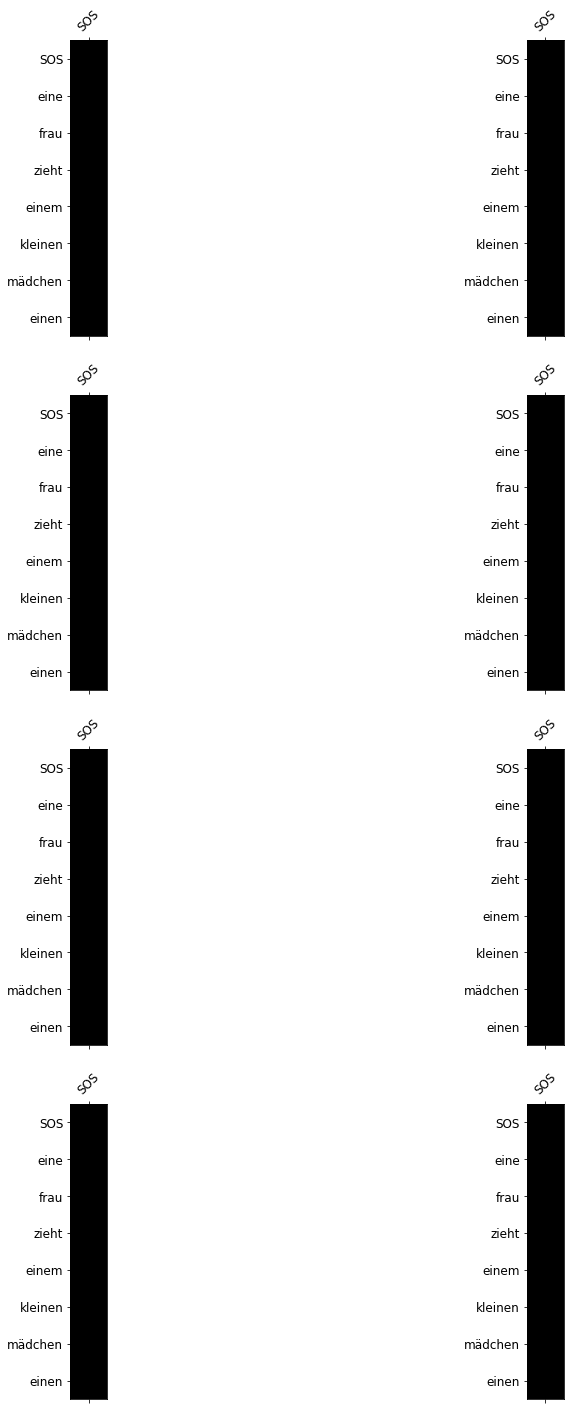

In [172]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

n_heads = 8
n_rows = 4
n_cols = 2

assert n_rows * n_cols == n_heads

fig = plt.figure(figsize=(15,25))

for i in range(n_heads):
    
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    
    _attention = attention_.squeeze(0)[i].cpu().detach().numpy()

    cax = ax.matshow(_attention, cmap='bone')

    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+sentence, rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
plt.close()